# Python package

We start with importing a few things we'll need. All required packages are installed during the setup process. 

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from openbabel.pybel import readfile

from delfta.calculator import DelftaCalculator
from delfta.utils import DATA_PATH

Next, we read a few example molecules. For more details on how to input your own molecules, see the documentation of the Pybel API [here](https://open-babel.readthedocs.io/en/latest/UseTheLibrary/Python_PybelAPI.html).

In [2]:
mol_files = glob.glob(os.path.join(DATA_PATH, "test_data", "*.sdf"))
mols = [next(readfile("sdf", mol_file)) for mol_file in mol_files]

We'll initialize a calculator by stating which tasks we want to perform. Options are `all` (the default), `E_form`, `E_homo`, `E_lumo`, `E_gap`, `dipole`, and `charges`. You can also choose between `delta=True` (run a GNF2-xTB calculation and predict a delta correction to obtain an approximation of the DFT-value) or `delta=False` (predict the DFT-value directly from the molecular structure).

In [48]:
calc_delta = DelftaCalculator(tasks=["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges"], delta=True) # Verbose passing of arguments. We could've used "all" as well
predictions_delta = calc_delta.predict(mols)
calc_direct = DelftaCalculator(tasks=["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges"], delta=False)
predictions_direct = calc_direct.predict(mols)

2021/06/22 04:26:29 PM | DelFTa | INFO: Now running network for model single_energy_delta...
2021/06/22 04:26:35 PM | DelFTa | INFO: Now running network for model charges_delta...
2021/06/22 04:26:40 PM | DelFTa | INFO: Now running network for model multitask_delta...
2021/06/22 04:26:45 PM | DelFTa | INFO: Now running xTB...


ValueError: setting an array element with a sequence.

In [4]:
df = pd.DataFrame(predictions_delta)
df.insert(0, "structure", [os.path.basename(mol_file) for mol_file in mol_files])
df.rename(columns={"E_form": "E_form [Ha]", "E_homo": "E_homo [Ha]", "E_lumo": "E_lumo [Ha]", "E_gap": "E_gap [Ha]", "dipole": "dipole [D]", "charges": "charges [e]"})

,structure,E_form [Ha],E_homo [Ha],E_lumo [Ha],E_gap [Ha],dipole [D]
0,CHEMBL4289810_conf_02.sdf,-16.472244,-0.301884,0.007817,0.309563,13.094598
1,CHEMBL3903980_conf_00.sdf,-11.918853,-0.308223,-0.016024,0.292466,9.587653
2,CHEMBL2435942_conf_01.sdf,-12.358029,-0.318627,0.013783,0.332709,5.714915
3,CHEMBL3912963_conf_01.sdf,-13.600934,-0.266440,0.037594,0.303944,2.964672
4,CHEMBL2348937_conf_01.sdf,-7.514140,-0.288944,-0.015563,0.273826,5.199066
...,...,...,...,...,...,...
95,CHEMBL3917059_conf_01.sdf,-13.623294,-0.273591,0.009193,0.283267,11.054542
96,CHEMBL227326_conf_00.sdf,-11.970598,-0.287543,0.028540,0.316302,2.909478
97,CHEMBL1083965_conf_00.sdf,-7.986115,-0.285511,0.000992,0.286689,2.669335
98,CHEMBL209490_conf_02.sdf,-11.515917,-0.298342,0.032551,0.330902,3.573202


In [5]:
dft_keys = ["DFT:FORMATION_ENERGY", "DFT:HOMO_ENERGY", "DFT:LUMO_ENERGY", "DFT:HOMO_LUMO_GAP", "DFT:DIPOLE"]
dft_values = {}
for dft_key in dft_keys:
    if dft_key == "DFT:DIPOLE": 
        dft_values[dft_key] =  [float(mol.data[dft_key].split("|")[-1]) for mol in mols]
    else:
        dft_values[dft_key] = [float(mol.data[dft_key]) for mol in mols]



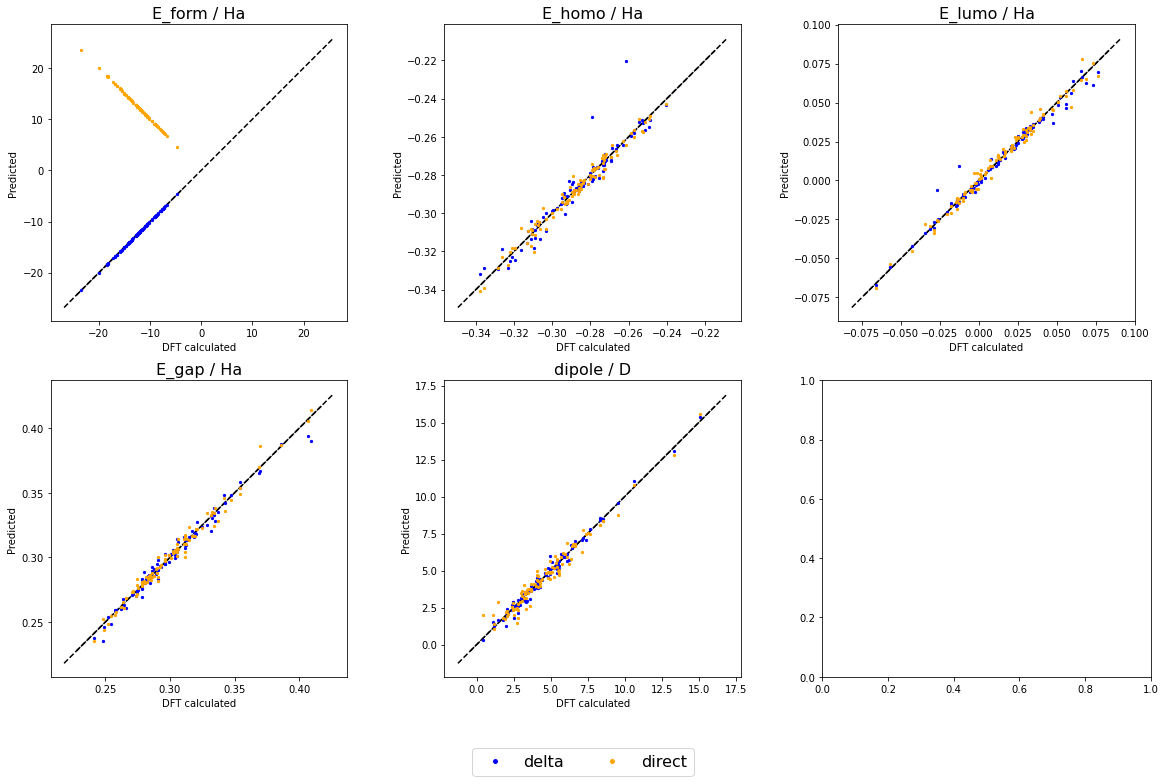

In [46]:
def make_plot(ax, dft_vals, pred_vals, label, unit, color): 
    ax.scatter(dft_vals, pred_vals, color=color, s=5)
    ax.set_xlabel("DFT calculated")
    ax.set_ylabel("Predicted")
    min_val = [min(ax.get_ylim()[0], ax.get_xlim()[0])]
    max_val = [max(ax.get_ylim()[1], ax.get_xlim()[1])]
    ax.plot([min_val, max_val], [min_val, max_val], '--', color="black", zorder=-1)
    ax.set_aspect("equal", "box")

fig = plt.figure(figsize=(20, 12))
gs = GridSpec(nrows=2, ncols=3)
pred_keys = ["E_form", "E_homo", "E_lumo", "E_gap", "dipole"]
all_dft_vals = [dft_values[dft_key] for dft_key in dft_keys]
all_pred_vals_delta = [predictions_delta[pred_key] for pred_key in pred_keys]
all_pred_vals_direct = [predictions_direct[pred_key] for pred_key in pred_keys]
units = ["Ha", "Ha", "Ha", "Ha", "D"]
axes = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(3)]
for ax, dft_vals, pred_vals_delta, pred_vals_direct, label, unit in zip(axes, all_dft_vals, all_pred_vals_delta, all_pred_vals_direct, pred_keys, units): 
    make_plot(ax, dft_vals, pred_vals_delta, label, unit, "blue")
    make_plot(ax, dft_vals, pred_vals_direct, label, unit, "orange")
    ax.title.set_text(f"{label} / {unit}")
    ax.title.set_fontsize(16)

handles = [Line2D([0], [0], marker='o', color="white", markerfacecolor="blue"), Line2D([0], [0], marker='o', color="white", markerfacecolor="orange")]
fig.legend(handles, ["delta", "direct"], fontsize=16, loc="lower center", ncol=2)

In [47]:
df

,structure,E_form,E_homo,E_lumo,E_gap,dipole
0,CHEMBL4289810_conf_02.sdf,-16.472244,-0.301884,0.007817,0.309563,13.094598
1,CHEMBL3903980_conf_00.sdf,-11.918853,-0.308223,-0.016024,0.292466,9.587653
2,CHEMBL2435942_conf_01.sdf,-12.358029,-0.318627,0.013783,0.332709,5.714915
3,CHEMBL3912963_conf_01.sdf,-13.600934,-0.266440,0.037594,0.303944,2.964672
4,CHEMBL2348937_conf_01.sdf,-7.514140,-0.288944,-0.015563,0.273826,5.199066
...,...,...,...,...,...,...
95,CHEMBL3917059_conf_01.sdf,-13.623294,-0.273591,0.009193,0.283267,11.054542
96,CHEMBL227326_conf_00.sdf,-11.970598,-0.287543,0.028540,0.316302,2.909478
97,CHEMBL1083965_conf_00.sdf,-7.986115,-0.285511,0.000992,0.286689,2.669335
98,CHEMBL209490_conf_02.sdf,-11.515917,-0.298342,0.032551,0.330902,3.573202
